## Setup
This section hold cells which:
- setup ipython preferences
- import needed modules
- define the set_seed function
- connect to google drive (comment out if not wanted)
- check the device we are running on (cpu or gpu via cuda)

In [0]:
# ipython setup
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 51kB 25.3MB/s 
     |████████████████████████████████| 491kB 41.1MB/s 
     |████████████████████████████████| 215kB 48.7MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.3 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
Populating the interactive namespace from numpy and matplotlib


In [0]:
# imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

In [0]:
# define the seed function
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

In [0]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
# check running device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## 1) Loading CIFAR10 from torchvision.datasets

This section loads, views and normalises the CIFAR10 data.

In [0]:
from torchvision.datasets import CIFAR10 

cifar_train = CIFAR10("./", download=True, train=True)
cifar_test = CIFAR10("./", download=True, train=False)

0it [00:00, ?it/s]

100%|█████████▉| 170401792/170498071 [02:55<00:00, 607446.97it/s]

Files already downloaded and verified


### 2) Plotting 25 examples with their class labels
First I need to know the shapes and types that the data is stored in

In [0]:
print(type(cifar_train.data), type(cifar_train.targets), type(cifar_test.data), type(cifar_test.targets))
print(cifar_train.data.shape, cifar_test.data.shape)

<class 'numpy.ndarray'> <class 'list'> <class 'numpy.ndarray'> <class 'list'>
(50000, 32, 32, 3) (10000, 32, 32, 3)


This format is ideal for plotting as imshow accepts a $m\times n\times 3$ input with the last dimension being RGB values.

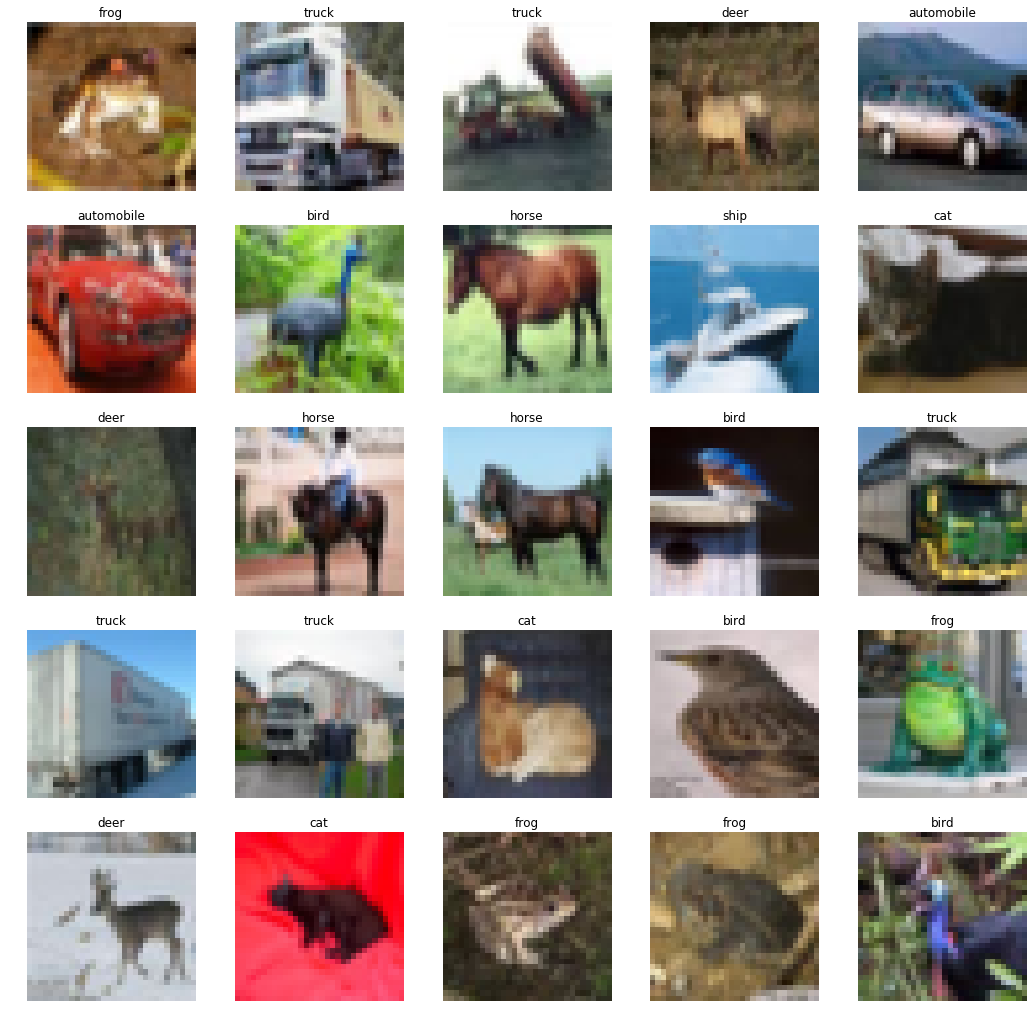

In [0]:
# setup the figure
fig, ax = plt.subplots(5, 5, figsize=[18,18])

# for each of the first 25 samples
for feat, targ, ax in zip(cifar_train.data[:5*5],
                          cifar_train.targets[:5*5],
                          ax.flatten()):
    ax.imshow(feat)
    ax.set(title=cifar_train.classes[targ])
    ax.axis("off")

### Normalise the data

I do this before splittng so that I don not need to normalise more than two data sets. First we need to seperate the features and targets for both training and test data.

In [0]:
train_feat = cifar_train.data
train_targ = cifar_train.targets
test_feat = cifar_test.data
test_targ = cifar_test.targets

We alreagy know that the data is in a shape and of types that are not ideal for using torch packages, sho we should chage this. First swap data axis so that we have (samples, channels, dim_x, dim_y) shape and then convert into tourch tensors of correct type.

In [0]:
# swap data axis to (samples, channels, dim_x, dim_y)
train_feat = np.swapaxes(train_feat, 2, 3)
train_feat = np.swapaxes(train_feat, 1, 2)

test_feat = np.swapaxes(test_feat, 2, 3)
test_feat = np.swapaxes(test_feat, 1, 2)


# convert to tourch tensors
train_feat = torch.from_numpy(train_feat).float()
test_feat = torch.from_numpy(test_feat).float()

train_targ = torch.tensor(train_targ).long()
test_targ = torch.tensor(test_targ).long()

Now we should notmalise the data along each channel independently, so we need the mean and standard deviation for each RGB channel. I will find these using the training features only and then use the same tranformation for both training and test features.

In [0]:
# find the mean and std values of each channel
means = train_feat.mean(dim=(0,2,3))
stds = train_feat.std(dim=(0,2,3))
print(means, stds)

tensor([125.3069, 122.9501, 113.8660]) tensor([62.9932, 62.0887, 66.7049])


Now we can write the normalise transforamtion funcion. If this were computationally intensive this could be apply to the data loaders later for parallel implementation, but here this is computationally cheap so I will apply the tranformations now as part of the pre-processing.

In [0]:
# define the normalisation
def normalise(X):
    
    assert X.dtype == torch.float32, "must have correct data type else kernal will crash"
    
    for mean, std, i in zip(means, stds, range(3)):
        X[:, i, :, :] -= mean
        X[:, i, :, :] /= std
            
    return X

In [0]:
# apply to the features
train_feat = normalise(train_feat)
test_feat = normalise(test_feat)

Lets ensure the output data have properties that we expect before we go on to define our network.

In [0]:
# check the final data looks like what we want
for data, data_name in zip([train_feat, train_targ, test_feat, test_targ], 
                           ["train_feat", "train_targ", "test_feat", "test_feat"]):
    
    print(data_name)
    
    for name, code in zip(["shape", "mean", "std", "max", "min", "type", "cuda"],
                          ["data.size()", "data.mean(dim=(0,2,3))", "data.std(dim=(0,2,3))", 
                           "data.max()", "data.min()", "data.dtype", "data.is_cuda"]):
        try:
            exec("print('\t', name, '\t:\t', " + code + ")")
        except:
            print("\t", name, "\t:\t undefined")

train_feat
	 shape 	:	 torch.Size([50000, 3, 32, 32])
	 mean 	:	 tensor([ 2.8650e-07,  3.9458e-06, -9.2133e-06])
	 std 	:	 tensor([1.0000, 1.0000, 1.0000])
	 max 	:	 tensor(2.1268)
	 min 	:	 tensor(-1.9892)
	 type 	:	 torch.float32
	 cuda 	:	 False
train_targ
	 shape 	:	 torch.Size([50000])
	 mean 	:	 undefined
	 std 	:	 undefined
	 max 	:	 tensor(9)
	 min 	:	 tensor(0)
	 type 	:	 torch.int64
	 cuda 	:	 False
test_feat
	 shape 	:	 torch.Size([10000, 3, 32, 32])
	 mean 	:	 tensor([0.0114, 0.0122, 0.0148])
	 std 	:	 tensor([0.9985, 0.9976, 1.0000])
	 max 	:	 tensor(2.1268)
	 min 	:	 tensor(-1.9892)
	 type 	:	 torch.float32
	 cuda 	:	 False
test_feat
	 shape 	:	 torch.Size([10000])
	 mean 	:	 undefined
	 std 	:	 undefined
	 max 	:	 tensor(9)
	 min 	:	 tensor(0)
	 type 	:	 torch.int64
	 cuda 	:	 False


Now we have our input data:
- of the correct shape (samples, channels, dim_x, dim_y)
- of the correct type (torch.float32 and torch.long)
- centered along each channel, i.e. with a mean~0 (not exact for test data as the means calcualted from training data only)
- normalised along each channel, i.e. std~1 (also not exact for test data)

Just to ensure that we have normalised and reshaped sensibly I will plot the first image again (note this has to be done as 3 seperate plots since imshow expects a certain image shape)

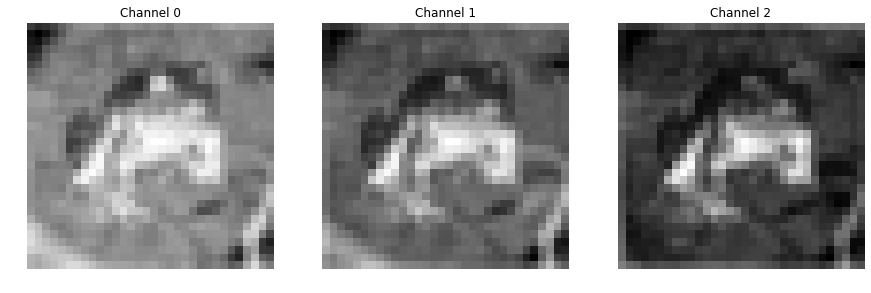

In [0]:
# sanity check
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].imshow(train_feat[0, i, :, :], cmap='gray')
    axs[i].set(title="Channel %i" %i)
    axs[i].axis("off")

This is still a frog!

### 3) Instantiate and create a StratifiedShuffleSplit using scikit-learn
First I need to create the list od indices to split with and check these are of the size we expect.

In [0]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
shuffler = shuffler.split(train_feat, train_targ)

indices = list(shuffler)[0]
print(indices[0].shape, indices[1].shape)

(45000,) (5000,)


Now to create the train and validation sets. I have named them featurse_XX where XX is the percent split so that I still have the full training set (train_feat and train_targ) for later use.

In [0]:
features_90 = train_feat[indices[0]]
targets_90 = train_targ[indices[0]]
features_10 = train_feat[indices[1]]
targets_10 = train_targ[indices[1]]

print(features_90.size(), targets_90.size(), features_10.size(), targets_10.size())

torch.Size([45000, 3, 32, 32]) torch.Size([45000]) torch.Size([5000, 3, 32, 32]) torch.Size([5000])


These have the sizes we expect

### Define Hyper Parameters
I need to define these before I create the dataloaders as batch and test batch sizes are needed for the data loaders.

In [0]:
# Other Hyperparameters
Seed = 42
Learning_Rate = 1e-2
Momentum = 0.5
Batch_Size = 64
Test_Batch_Size = 1000
Number_of_Epochs = 30

### 4) Instantiate a torch.utils.data.TensorDataset for training, validation and test data

I define the dataloaders at the same time as the datasets because the data will not be changed once it is in the dataset. I choose shuffle to be False as it often leads to noisy behaviour in the validation loss and accuracy plots.

In [0]:
# datasets
train_dataset    = TensorDataset(features_90, targets_90)
validate_dataset = TensorDataset(features_10, targets_10)
test_dataset     = TensorDataset(test_feat,   test_targ)

# dataloaders
shf = False
train_loader    = DataLoader(train_dataset, batch_size=Batch_Size, shuffle=shf)
validate_loader = DataLoader(validate_dataset, batch_size=Test_Batch_Size, shuffle=shf)
test_loader     = DataLoader(test_dataset, batch_size=Test_Batch_Size, shuffle=shf)

## 5) Modify LeNet5 for CIFAR10
The only change that is needed is for network archetecture is in the first layer, which now:
- no longer needs padding (input image is 32x32 now rather than 28x28)
- has three input channels rather than one
every other layer is the same as LeNet5 from literature (and lectures) shown below

Note I also added biases which we did not in the lecture version of LeNet5 because I expect these to improve the quality of this classifier here, provided we don't overfit. I actually did the whole training without biases (not shown here) and found that the average max validation accuracy was around 2% worse.

![alt text](https://cdn-images-1.medium.com/max/2400/1*1TI1aGBZ4dybR6__DI9dzA.png)


In [0]:
class LeNet5_CIFAR10(nn.Module):
    """
    The LeNet5 neural network architecture for a 3 channel 32x32
    input as expected from the CIFAR10 dataset
    """

    def __init__(self, bias=True):
        "setup the neural network"
        
        # initalise
        super(LeNet5_CIFAR10, self).__init__()

        # general params
        kernal = 5
        stride = 1

        # create each layer
        self.C1_layer = nn.Conv2d(3, 6, padding=0, kernel_size=kernal, stride=stride, bias=bias)
        self.C3_layer = nn.Conv2d(6, 16, padding=0, kernel_size=kernal, stride=stride, bias=bias)
        
        self.S2_layer = nn.MaxPool2d(kernel_size=2, stride=2)        
        self.S4_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.F5_layer = nn.Linear(16*5*5, 120, bias=bias)
        self.F6_layer = nn.Linear(120,84, bias=bias)
        
        self.output = nn.Linear(84, 10, bias=bias)
        
        # create the activation function
        act = nn.ReLU()
        
        # create a list of fucntion order
        self.layers = [self.C1_layer, act, 
                       self.S2_layer, act, 
                       self.C3_layer, act, 
                       self.S4_layer, act, self.flatten, 
                       self.F5_layer, act,
                       self.F6_layer, act,
                       self.output]
        
    def flatten(self, T):
        "flatten the image for the fully connected layers"
        return T.view(-1, 16*5*5)
        
        
    def forward(self, x):
        "Pass through the neural network"
        for f in self.layers:
            x = f(x)
        return x

I should test this behaves for a forward pass of a random sample with the correct shape. I will also see how many parameters I have in total because it is interesting.

In [0]:
x = torch.randn((1, 3, 32, 32))
model = LeNet5_CIFAR10()
y = model(x)
print("Output (pre-softmax):\n", y.detach().numpy())
n_params = sum([t.detach().numpy().size for t in model.parameters()])
print("Number of model Parameters: ", n_params)

Output (pre-softmax):
 [[ 0.02592786  0.03131023  0.11026245 -0.13019848  0.02250747 -0.07941735
   0.00020191 -0.0275333   0.10076308 -0.11753833]]
Number of model Parameters:  62006


### Define Train, Validation and Evaluate Functions
Here I choose to use a class wrapper around the train_model, train, validate and test methods from lectures, so that all these are nicely kept together.

In [0]:
class train_wrapper():
    """
    Class that keeps a model, its optimiser and dataloaders together.
    Stores the train, validate and evaluate functions for training as well
    as some other useful methods to carry out the training with a love plot
    and save the model.
    """
    
    def __init__(self, model, optimizer, train_loader, validate_loader,
                 test_loader, criterion=nn.CrossEntropyLoss(), device="cpu"):
        "Stores the parameters on the class instance for later methods"
        
        for arg in ["model", "optimizer", "train_loader", "validate_loader",
                    "test_loader", "criterion", "device"]:
            exec("self." + arg + "=" + arg)
        return
    
    
    def train(self):
        "Train a single epoch"
        
        # set the model expect a backward pass
        self.model.train()
        
        train_loss, train_accuracy = 0, 0
        
        # for every training batch
        for X, y in self.train_loader:
            
            # put the samples on the device
            X, y = X.to(self.device), y.to(self.device)
            
            # zero the gradent
            self.optimizer.zero_grad()
            
            # find the model output with current parameters
            output = self.model(X)
            
            # caclulate the loss for to the expect output
            loss = self.criterion(output, y)
            
            # propagate the gradients though the network
            loss.backward()
            
            # store the loss (scaled by batch size for averaging)
            train_loss += loss * X.size(0)
            
            # find the predictions from this output
            y_pred = F.log_softmax(output, dim=1).max(1)[1]
            
            # compare to expected output to find the accuracy
            train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
            
            # improve the parameters
            self.optimizer.step()

        # return the mean loss and accuracy of this epoch
        N_samp = len(self.train_loader.dataset)
        return train_loss/N_samp, train_accuracy/N_samp
    
    
    def validate(self):
        """
        Find the loss and accuracy of the current model parameters to the
        validation data set
        """
        
        # if no validation set present return zeros
        if self.validate_loader == None:
            return torch.tensor(0.), torch.tensor(0.)
        
        # set the model to not expect a backward pass
        self.model.eval()
        
        validation_loss, validation_accuracy = 0., 0.
        
        # for every validate batch
        for X, y in self.validate_loader:
            
            # tell the optimizer not to store gradients
            with torch.no_grad():
                
                # put the samples on the device
                X, y = X.to(self.device), y.to(self.device)
                
                # find the model output with current parameters
                output = self.model(X)
                
                # caclulate the loss for to the expect output
                loss = self.criterion(output, y)
                
                # store the loss (scaled by batch size for averaging)
                validation_loss += loss * X.size(0)
                
                # find the predictions from this output
                y_pred = F.log_softmax(output, dim=1).max(1)[1]
                
                # compare to expected output to find the accuracy
                validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
        
        # return the mean loss and accuracy of this epoch
        N_samp = len(self.validate_loader.dataset)
        return validation_loss/N_samp, validation_accuracy/N_samp
    
    
    def evaluate(self):
        """
        Find the prediction of the current model parameters with the test
        data set and return both the predicted and actual labels
        """
        
        # set the model to not expect a backward pass
        self.model.eval()
        
        ys, y_preds = [], []
        
        # for every test batch
        for X, y in self.test_loader:
        
            # tell the optimizer not to store gradients
            with torch.no_grad():
                
                # put the samples on the device
                X, y = X.to(self.device), y.to(self.device)
                
                # find the model output with current parameters
                output = self.model(X)
                
                # find the predictions from this output
                y_pred = F.log_softmax(output, dim=1).max(1)[1]
                
                # store the predicted and actual outcomes
                ys.append(y.cpu().numpy())
                y_preds.append(y_pred.cpu().numpy())

        # return the list of predictions and actual targets
        return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)
    
    
    def train_model(self, epochs):
        """
        Do a live plot of the training accuracy and loss as the model is trained
        """
        
        # store the liveloss as it holds all our logs, useful for later
        self.liveloss = PlotLosses()
        
        for epoch in range(epochs):
            logs = {}
            train_loss, train_accuracy = self.train()

            logs['' + 'log loss'] = train_loss.item()
            logs['' + 'accuracy'] = train_accuracy.item()

            validation_loss, validation_accuracy = self.validate()
            logs['val_' + 'log loss'] = validation_loss.item()
            logs['val_' + 'accuracy'] = validation_accuracy.item()

            self.liveloss.update(logs)
            self.liveloss.draw()
            
        print("Training Finished")
        return
    
    
    def save_model(self, name, path=F"/content/gdrive/My Drive/models/", only_params=False):
        """
        Pickel either the whole model or its parameter dictionary
        via torch's save methods
        """
        
        if only_params:
            torch.save(self.model.state_dict(), path + name)
        else:
            torch.save(self.model, path + name)
        
        print("saved to " + path + name)
            

## 6) Perform a hyperparameter search of the Weight-Decay Parameter using the train/validation split¶

### Weight Decay = 0.

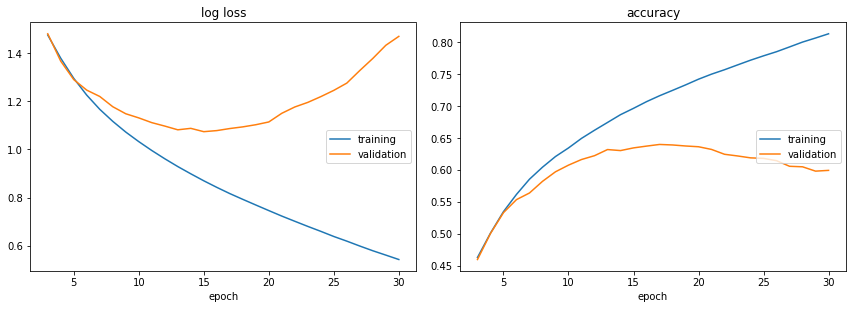

log loss:
training   (min:    0.543, max:    2.068, cur:    0.543)
validation (min:    1.074, max:    1.831, cur:    1.470)

accuracy:
training   (min:    0.236, max:    0.813, cur:    0.813)
validation (min:    0.340, max:    0.640, cur:    0.599)
Training Finished


In [0]:
set_seed(Seed)
model_0 = LeNet5_CIFAR10().to(device)
optimizer = torch.optim.SGD(model_0.parameters(), lr=Learning_Rate, momentum=Momentum, weight_decay=0.)
criterion = nn.CrossEntropyLoss()

wrapper_0 = train_wrapper(model_0, optimizer, train_loader, validate_loader, test_loader, criterion, device)
wrapper_0.train_model(Number_of_Epochs)

### Weight Decay = 1e-3

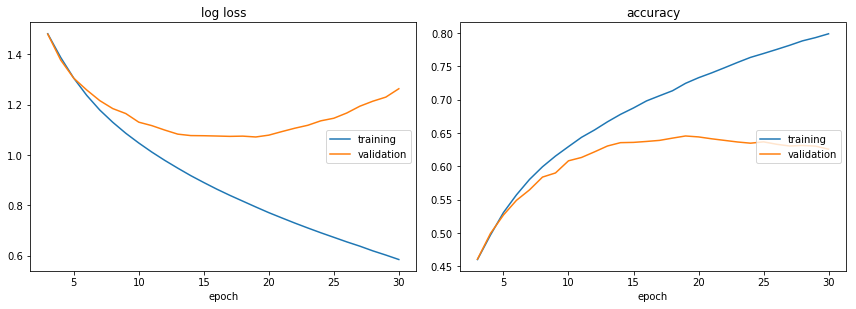

log loss:
training   (min:    0.584, max:    2.070, cur:    0.584)
validation (min:    1.071, max:    1.835, cur:    1.263)

accuracy:
training   (min:    0.235, max:    0.799, cur:    0.799)
validation (min:    0.337, max:    0.645, cur:    0.626)
Training Finished


In [0]:
set_seed(Seed)
model_3 = LeNet5_CIFAR10().to(device)
optimizer = torch.optim.SGD(model_3.parameters(), lr=Learning_Rate, momentum=Momentum, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

wrapper_3 = train_wrapper(model_3, optimizer, train_loader, validate_loader, test_loader, criterion, device)
wrapper_3.train_model(Number_of_Epochs)

### Weight Decay = 1e-4


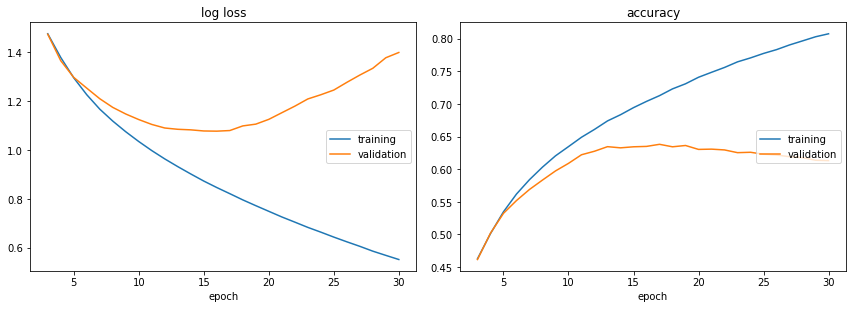

log loss:
training   (min:    0.551, max:    2.068, cur:    0.551)
validation (min:    1.077, max:    1.836, cur:    1.399)

accuracy:
training   (min:    0.236, max:    0.808, cur:    0.808)
validation (min:    0.338, max:    0.638, cur:    0.613)
Training Finished


In [0]:
set_seed(Seed)
model_4 = LeNet5_CIFAR10().to(device)
optimizer = torch.optim.SGD(model_4.parameters(), lr=Learning_Rate, momentum=Momentum, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

wrapper_4 = train_wrapper(model_4, optimizer, train_loader, validate_loader, test_loader, criterion, device)
wrapper_4.train_model(Number_of_Epochs)

### Weight Decay = 1e-5

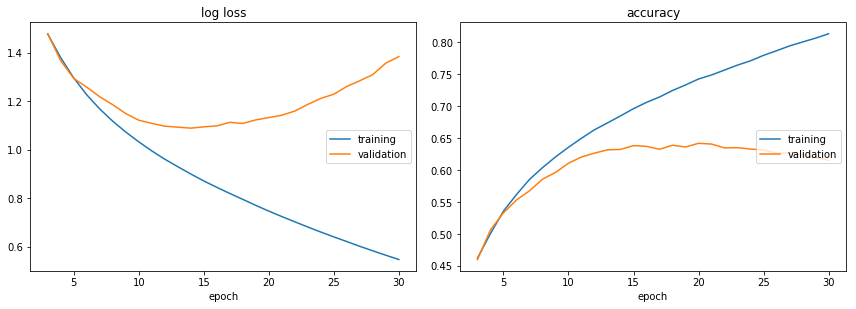

log loss:
training   (min:    0.548, max:    2.067, cur:    0.548)
validation (min:    1.089, max:    1.829, cur:    1.383)

accuracy:
training   (min:    0.236, max:    0.813, cur:    0.813)
validation (min:    0.339, max:    0.642, cur:    0.615)
Training Finished


In [0]:
set_seed(Seed)
model_5 = LeNet5_CIFAR10().to(device)
optimizer = torch.optim.SGD(model_5.parameters(), lr=Learning_Rate, momentum=Momentum, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

wrapper_5 = train_wrapper(model_5, optimizer, train_loader, validate_loader, test_loader, criterion, device)
wrapper_5.train_model(Number_of_Epochs)

### Comparing Performance
Though we have all the values stated above lets look at them side by side. Since we have the liveloss stored on the wrapper objects we can just access the training logs again. Since the final validation accuracy might be affected by some of the random vairations in the parameter tuning and/or possibly affected by overfitting I will compare the max accuracies instead of the final accuracy.

In [0]:
# calculate the final validation accuracies again
wrappers = [wrapper_0, wrapper_3, wrapper_4, wrapper_5]
max_acc = [w.liveloss.metrics_extrema['val_accuracy']['max'] for w in wrappers]
decays = [0., 1e-3, 1e-4, 1e-5]

# print them in a table
print("Decay \t| Max Accuracy (%)", "\n-------------------------")
for accuracy, decay in zip(max_acc, decays):
    print(decay, "\t| %.2f " % (accuracy*100))

Decay 	| Max Accuracy (%) 
-------------------------
0.0 	| 63.96 
0.001 	| 64.54 
0.0001 	| 63.82 
1e-05 	| 64.18 


We see that a weight decay of $10^{-3}$ is around slightly better than the next best parameter choice, hence that is the one I shall use (though some more in depth analysis would be needed to be confident in this selection along with the other hyper parameters).

## 7) Train the model with the best weight-decay parameter
First I need to create the data loader for the full training dataset, fortuneately I kept the normalised full training targets and features from earlier (as train_feat and train_targ).

In [0]:
full_dataset = TensorDataset(train_feat, train_targ)
full_loader = DataLoader(full_dataset, batch_size=Batch_Size, shuffle=False, num_workers=0)
print(len(full_loader.dataset))

50000


This is the correct size so I am ready to train on this. Note here I set the validate_loader to None which instructs the train_wrapper classes to set validation log loss and accuracy as zero (since we have no validation set to compare with).

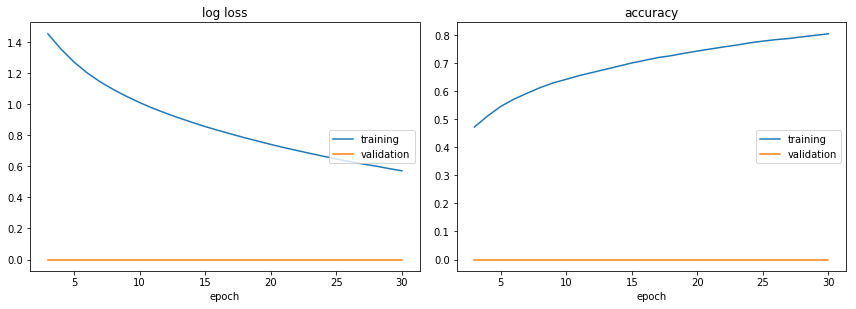

log loss:
training   (min:    0.571, max:    2.043, cur:    0.571)
validation (min:    0.000, max:    0.000, cur:    0.000)

accuracy:
training   (min:    0.247, max:    0.805, cur:    0.805)
validation (min:    0.000, max:    0.000, cur:    0.000)
Training Finished


In [0]:
set_seed(Seed)
model_opt = LeNet5_CIFAR10().to(device)
optimizer = torch.optim.SGD(model_opt.parameters(), lr=Learning_Rate, momentum=Momentum, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

wrapper_opt = train_wrapper(model_opt, optimizer, full_loader, None, test_loader, criterion, device)
wrapper_opt.train_model(Number_of_Epochs)

Now to test the accuracy of this model.

In [0]:
# find the predicted and acutal outcomes
predion, actual = wrapper_opt.evaluate()

# first method to find the accuracy
acc1 = (predion == actual).mean() * 100
print("Accuracy: %.2f" % acc1 + "%")

# second method to find the accuracy
acc2 = accuracy_score(predion, actual) * 100
print("Accuracy: %.2f" % acc2 + "%")

Accuracy: 64.71%
Accuracy: 64.71%


This accuracy is better than the validation accuracies of all methods, but only slighly better than the validaion accuracy of the weight decay $10^{-3}$ which is to be expected as here we had $10\%$ more data to train with.


What I found initially surprising is that this accuracy is worse than MNIST or MNIST Fashon, despite there being more input channels with the same number of target labels. 
The key factor here I belive is that the MNIST inputs are much cleaner, anything that is not the subject image is zero just about every feature is relevant. Here however we have real world images with backgounds that need to be screened out, so despite more input features there is less accuracy. There are of course several other factors that influence this such as the netowrk archetecture with regard to underlying districutions and the curse of dimensionality.

### 8. Store the final model to disk
Note here I am saving to my google drive modules folder as default (this can be changed by passing in a path parameter)

In [0]:
wrapper_opt.save_model(name="CIFAR10_classifier.pth", only_params=False)

saved to /content/gdrive/My Drive/models/CIFAR10_classifier.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LeNet5_CIFAR10. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


To Ensure this was saved correctly I will load it and check the prediction accuracy matches that above.

In [0]:
model_loaded = torch.load(F"/content/gdrive/My Drive/models/CIFAR10_classifier.pth")

In [0]:
wrapper_loeaded = train_wrapper(model_loaded, None, None, None, test_loader, device=device)

# find the predicted and acutal outcomes
predion, actual = wrapper_loeaded.evaluate()
acc1 = (predion == actual).mean() * 100
print("Accuracy: %.2f" % acc1 + "%")

Accuracy: 64.71%


This matches so we know it is all good :) 

### Extra) Recognising Overfitting

In the previous line search models I notice that there is some overfitting to the training data. The log loss functions increase after about 15 epochs, which in itself can hapen without overfitting. What is evidence however is that each validaiton accuracy decreases from its maximum by epoch 30. This can be seen by looking at the previous plots.

There are many ways to combat overfiiting such as data augmentation, dropout or changing the network architecture. The simplest method is actually just to stop training at the epoch before overfitting begins to happen, which I will try now.

First lets find exactly what epoch gives the best validation accuracy.

In [0]:
# find the epoch at which max validation accuracy occured
max_val_epoch = []
for w in wrappers:
    max_acc = w.liveloss.metrics_extrema['val_accuracy']['max']
    for log in w.liveloss.logs:
        if log["val_accuracy"] == max_acc:
            max_val_epoch.append(log["_i"])
avg = np.mean(max_val_epoch).astype(int)
            
# print them in a table
print("Decay \t| Epoch", "\n----------------")
for epoch, decay in zip(max_val_epoch, decays):
    print(decay, "\t| %i " % epoch)
print("\nmean = ", avg)

Decay 	| Epoch 
----------------
0.0 	| 17 
0.001 	| 19 
0.0001 	| 17 
1e-05 	| 20 

mean =  18


Looks like around 18 is a good value to use, I will make a new model with this new train time just as before. 

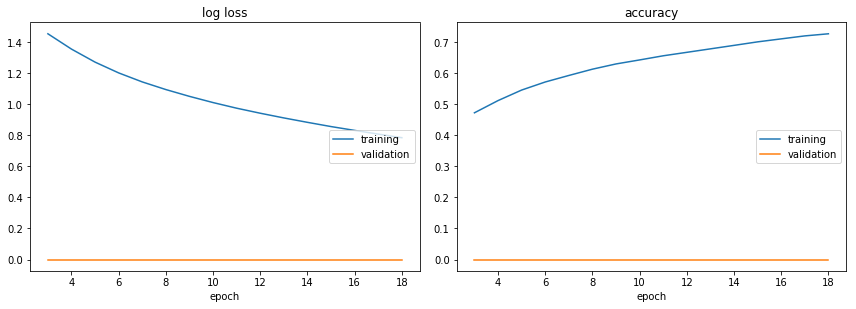

log loss:
training   (min:    0.784, max:    2.043, cur:    0.784)
validation (min:    0.000, max:    0.000, cur:    0.000)

accuracy:
training   (min:    0.247, max:    0.727, cur:    0.727)
validation (min:    0.000, max:    0.000, cur:    0.000)
Training Finished


In [0]:
set_seed(Seed)
model_best = LeNet5_CIFAR10().to(device)
optimizer = torch.optim.SGD(model_best.parameters(), lr=Learning_Rate, momentum=Momentum, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

wrapper_opt = train_wrapper(model_best, optimizer, full_loader, None, test_loader, criterion, device)
wrapper_opt.train_model(avg)

In [0]:
# find the predicted and acutal outcomes
predion, actual = wrapper_opt.evaluate()

# first method to find the accuracy
acc1 = (predion == actual).mean() * 100
print("Accuracy: %.2f" % acc1 + "%\n")

# save this model
wrapper_opt.save_model(name="CIFAR10_classifier_better.pth", only_params=False)

Accuracy: 65.54%

saved to /content/gdrive/My Drive/models/CIFAR10_classifier_better.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LeNet5_CIFAR10. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


We get an extra percent (which is actually not too bad when you think about it). I have saved this model too just so I never have to train it again.

## 9) Answer Questions
Below I identify which data augmentation methods I see as reasonable and why

#### Left-Right Flips - YES

For just about everything in this data set there no reasonable difference in the between left or right. If you flip a frong horizontally it is still a frog with features that the network should be able to identify.

#### Random Rotations by up to 10 Degrees - YES

Slight inclinations of an image does not change the images subject. Also it is expected that not all images are perfectally horizonal so this is inherent in the data set.

#### Up-Down Flips - NO

Whilst there is no a priori difference between left and right in a image there is between up and down. A human can still tell a upsidedown frog is a frog so in theory this should be ok, however in practice the position of certain features in an image are significant. A lory has wheels at its base not its top for example. Requiring the network to recognise images flipped like this is adding symmetry restrictions on its neurons that will likely hinder its performance and require more data to train effectively. The deciding factor for me would be should the trained neural network be expected to identify an upsidedwon lory, and for a large majorty of situations it should not need to.

#### Shifting up-down, left-right by 5 pixels - YES

The same as the first two, a shifted image is still the same subject. Even if the subject is split in half since the other half would be wrapped around the other side of the image the network should still be able to pick out key features to identify with.

#### Contrast Changes - YES (within reason)

Contrast changes are kind of like changing the lighting of the image at time of photo graphing in that it does not change what you are looking at or its key discernible traits. However large changes in contast can make an image unrecognisable to a human, which suggests caution must be taken here.

#### Adding Gaussian Noise - YES (within reason)

Some gaussian noise would make some features less noticeable as they become hidden in the noise with others still clearly visable, which should force the network to become more robust in a similar manner to dropout.

#### Random Rotations by up to 90 Degrees - NO

Just like with the verticle image inversion a 90 degree rotation will change the relative positions of features too much requiring a far more sophisticated netwrok to recognise the subject of each image. Like before, the deciding factor here is whether it is reasonable to ask a network to identfy a sideways horse.